## Analysing model confusion matrices

This notebook reproduces the model-human confusion matrix correlation analyses from the section _Recurrence does not make model mistakes more human-like_. Model confusion matrices are built and correlated with that of humans.

In [1]:
# General package imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, json
import scipy
from scipy.stats import sem
from matplotlib.lines import Line2D

In [2]:
# Import some useful lists
external_list_file = '../data/external/lists.json'

# Read the json lists from the external list file
lists = json.load(open(external_list_file))

# Extract the relevant lists from the data
tasks = lists['tasks']
task_difficulty = lists['task_difficulty']
models = lists['models']
model_sizes = lists['model_sizes']
model_names = lists['model_names']
model_names_size_ordered = lists['model_names_size_ordered']
model_palette = lists['model_palette']
model_architectures = lists['model_architectures']

Define a function to extract a confidence interval range, to return a star pattern from a p-value, and to remove the diagonal from & flatten a matrix.

In [3]:
def get_CI_range(data, confidence=0.95):
  '''
  Output:
    Difference between the mean and the lower boundary of the 95% CI around the mean.
  '''
  confidence_interval = scipy.stats.norm.interval(
    confidence=confidence,
    loc=np.mean(data),
    scale=scipy.stats.sem(data)
  )
  
  interval = np.mean(data) - confidence_interval[0]
  
  return interval

def p_to_star(pvalue):
    '''Takes a p value and returns the corresponding significance stars.'''
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

def remove_diag_flatten(matrix):
    '''
    Remove the diagonal of a matrix and return it flattened.
    '''
    return matrix[~(np.identity(matrix.shape[0], dtype=bool))].ravel()

Import the data.

In [4]:
# Import the data
cm_data = pd.read_pickle('../data/processed/confmats.pkl')
cm_reliability = pd.read_pickle('../data/processed/confmat_noise_ceilings.pkl')

Parse it out.

In [5]:
## Parse the data for each analysis

# Add up all the participants CM to one group-level CM
group_cm = np.sum(cm_data['participants'][s] for s in list(cm_data['participants'].keys()))

# Calculate the task-wise correlation with the general human accuracy
cm_seed_corr = [[np.corrcoef(remove_diag_flatten(cm_data[m][s]), remove_diag_flatten(group_cm))[1, 0] for s in range(20)] for m in models]
cm_mean_corr = [np.mean(cm_seed_corr[i]) for i in range(len(models))]
cm_sem_corr = [sem(cm_seed_corr[i]) for i in range(len(models))]
cm_ci_corr = [get_CI_range(cm_seed_corr[i]) for i in range(len(models))]

# Calculate the task-wise correlation with the no mask human accuracy
cm_nomask_seed_corr = [[np.corrcoef(remove_diag_flatten(cm_data[m][s]), remove_diag_flatten(cm_data['no mask']))[1, 0] for s in range(20)] for m in models]
cm_nomask_mean_corr = [np.mean(cm_nomask_seed_corr[i]) for i in range(len(models))]
cm_nomask_sem_corr = [sem(cm_nomask_seed_corr[i]) for i in range(len(models))]
cm_nomask_ci_corr = [get_CI_range(cm_nomask_seed_corr[i]) for i in range(len(models))]

# Calculate the task-wise correlation with the mask human accuracy
cm_mask_seed_corr = [[np.corrcoef(remove_diag_flatten(cm_data[m][s]), remove_diag_flatten(cm_data['mask']))[1, 0] for s in range(20)] for m in models]
cm_mask_mean_corr = [np.mean(cm_mask_seed_corr[i]) for i in range(len(models))]
cm_mask_sem_corr = [sem(cm_mask_seed_corr[i]) for i in range(len(models))]
cm_mask_ci_corr = [get_CI_range(cm_mask_seed_corr[i]) for i in range(len(models))]

# Merge eveything in a df to re-order it later
confmat_df = pd.DataFrame({
    'model': models,
    'size': model_sizes.values(),
    'cm mean':cm_mean_corr, 
    'cm sem': cm_sem_corr, 
    'cm ci': cm_ci_corr, 
    'cm no mask mean': cm_nomask_mean_corr, 
    'cm no mask sem': cm_nomask_sem_corr, 
    'cm no mask ci': cm_nomask_ci_corr, 
    'cm mask mean': cm_mask_mean_corr, 
    'cm mask sem': cm_mask_sem_corr, 
    'cm mask ci': cm_mask_ci_corr, 
})

/var/folders/kk/bx15r39d6p9gj2bpfsdppmn80000gn/T/ipykernel_55468/4228910044.py:4: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  group_cm = np.sum(cm_data['participants'][s] for s in list(cm_data['participants'].keys()))


Print some results.

In [6]:
for i in range(len(confmat_df)):
    print(
        f"Model {confmat_df['model'][i]}: overall correlation of {confmat_df['cm mean'][i]}.\n"
    )

Model cornet_z: overall correlation of 0.3850540137819131.

Model cornet_V1_V1: overall correlation of 0.36820358825899935.

Model cornet_IT_IT: overall correlation of 0.36466103127931276.

Model CORnet_RT: overall correlation of 0.3361886493604888.

Model TDnet: overall correlation of 0.3223255225139165.

Model FBnet: overall correlation of 0.3256072787300974.

Model cornet_zd: overall correlation of 0.43870195055748606.

Model cornet_s: overall correlation of 0.12376037179422068.

Model B_net_128: overall correlation of 0.2855785583454601.

Model BL_net_128: overall correlation of 0.17641149710711224.

Model BT_net_128: overall correlation of 0.21090876827521857.

Model bd: overall correlation of 0.34282208803068726.

Model BLT_net_128: overall correlation of 0.18641505331031996.

Model vgg11_bn_small: overall correlation of 0.3814076199806704.

Model vgg16_bn: overall correlation of 0.4508299064206945.



Define some styling elements.

In [7]:
# Define some colours
R_COLOUR = '#607A56' # One colour for recurrent models
FF_COLOUR = 'darkGray' # Another colour for non recurrent models
NOMASK_COLOUR = '#9FD07D' # Light green like on the poster
MASK_COLOUR = '#2C750F' # Darker shade of that green
EASY_COLOUR = 'white'
HARD_COLOUR = 'black'
legend_fontsize = 10.0 # 18 for posters
marker_size = 3.0 # 10 for posters
err_bar_dict={
    'elinewidth': 2.0,  # 12 for posters
    'capsize': 2.0,     # 4 for posters
}

Reproduce figure 7a and 7b.

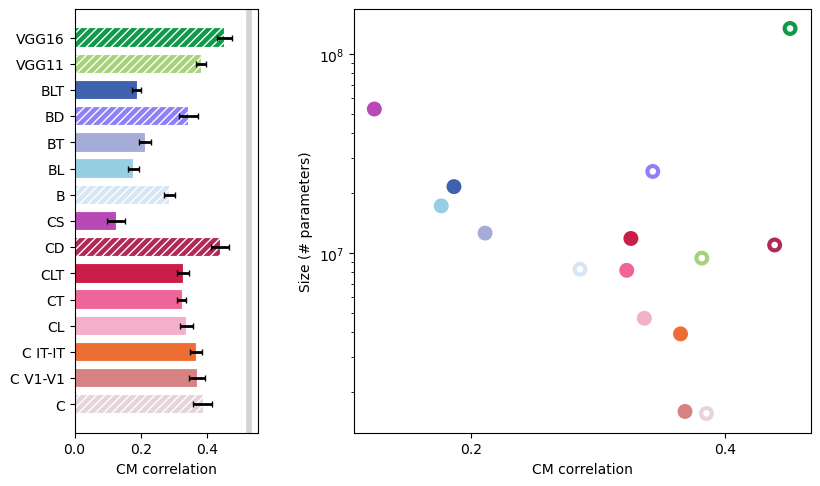

In [8]:
# First figure: model confmat correlation, model confmat correlation x size
fig, ax = plt.subplots(1, 2, figsize=(9.5, 5.5), gridspec_kw={'width_ratios': [2, 5]})

# Create the bar plot values
x_values = range(len(confmat_df))
y_values = confmat_df['cm mean']
# yerr = confmat_df['cm sem'] # to use SEM
yerr = confmat_df['cm ci'] # to use CI

# Left side of the plot - bars
bars = ax[0].barh(
    y=x_values,
    width=y_values,
    height=0.7,
    color=[model_palette[m] for m in confmat_df['model']],
    linewidth=0.1,
    edgecolor='white',
    hatch=['' if model_architectures[m]=="recurrent" else '////' for m in confmat_df['model']],
    xerr = yerr,
    error_kw=err_bar_dict
)
# Add noise ceiling
ax[0].axvline(np.mean(cm_reliability['across ppts']['cm']),color='lightGray', linewidth=4.0)
# Change the axes
# ax[0].set_xlim(0.55, 1.0)
ax[0].set_ylabel(None)
ax[0].set_xlabel('CM correlation')
ax[0].set_yticks(ticks=x_values, labels=[model_names[m] for m in confmat_df['model']])

# Right part of the plot
ax[1].set_ylabel('Size (# parameters)')
ax[1].set_yscale('log')
ax[1].set_xlabel('CM correlation')
# ax[1].set_ylim(0.59, 0.78)
ax[1].set_xticks(ticks=ax[1].get_xticks()[1:])
# Make the scatter plot
ax[1].scatter(
    y = confmat_df['size'],
    x = y_values,
    color=[model_palette[m] if model_architectures[m]=="recurrent" else 'white' for m in confmat_df['model']],
    edgecolor=[model_palette[m] for m in confmat_df['model']],
    linewidth=3.0,
    s = marker_size*20
)
# Adjust the distance between plots
plt.subplots_adjust(wspace=0.3)

Reproduce figure 7c.

Text(0.5, 1.0, 'Masked trials')

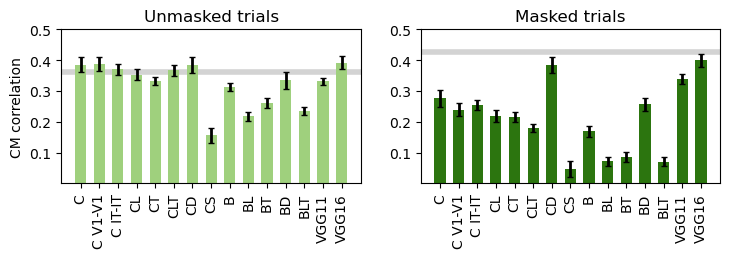

In [9]:
## Make two bar plots of average consistency, with and without mask

# Make the two plots next to one another
fig, ax = plt.subplots(1, 2, figsize=(8.5, 2.0))
bar_width = 0.6

# Left side of the plot - easy bars
ax[0].bar(x=range(len(confmat_df)), height=confmat_df['cm no mask mean'], width=bar_width,
          color=NOMASK_COLOUR, label='No mask', yerr = confmat_df['cm no mask ci'],
               error_kw= err_bar_dict, zorder=2)
# Add noise ceiling
ax[0].axhline(np.mean(cm_reliability['across ppts']['cm no mask']),color='lightGray', linewidth=4.0, zorder=0)
# Change the axes
ax[0].set_ylim(0.0, 0.5)
ax[0].set_yticks(ticks=ax[0].get_yticks()[1:])
ax[0].set_ylabel('CM correlation')
ax[0].set_xticks(range(len(confmat_df)), labels=[model_names[m] for m in confmat_df['model']], rotation = 90)
# Add a title
ax[0].set_title('Unmasked trials')

# Right side of the plot - challenging bars
ax[1].bar(x=range(len(confmat_df)), height=confmat_df['cm mask mean'], width=bar_width, 
          color=MASK_COLOUR, label='Mask', yerr = confmat_df['cm mask ci'],
               error_kw= err_bar_dict, zorder=2)
# Add noise ceiling
ax[1].axhline(np.mean(cm_reliability['across ppts']['cm mask']),color='lightGray', linewidth=4.0, zorder=0)
# Change the axes
ax[1].set_ylim(0.0, 0.5)
ax[1].set_yticks(ticks=ax[1].get_yticks()[1:])
ax[1].set_xticks(range(len(confmat_df)), labels=[model_names[m] for m in confmat_df['model']], rotation = 90)
# Add a title
ax[1].set_title('Masked trials')